In [5]:
import time
import random
from typing import Optional, List, Dict, Union, Any
from itertools import chain
from pathlib import Path

from selectorlib import Extractor
import requests
import numpy as np
import pandas as pd
import plotly.express as px

In [ ]:
extractor = Extractor.from_yaml_file('selectors.yml')

In [ ]:
def format_rating(rating: str) -> Union[float, None]:
    try:
        rate = rating.split()[0]
        return eval(rate)
    except (AttributeError, IndexError):
        pass

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [10]:
vds = SentimentIntensityAnalyzer()

In [11]:
def label_sentiment(text: str) -> int:
    sentiment_stats = vds.polarity_scores(text)
    sentiment = sentiment_stats['compound']
    
    if sentiment >= 0.05:
        return 'positive'
    elif (sentiment > -0.05) and (sentiment < 0.05):
        return 'neutral'
    else:
        return 'negative'

In [12]:
df_copy['sentiment'] = df_copy.content.apply(lambda x: label_sentiment(x) if isinstance(x, str) else x)

In [3]:
data_path = lambda filename: Path.joinpath(Path.cwd().parent, 'data', filename)

In [6]:
df = pd.read_csv(data_path('keychron_K2_reviews.csv'))

In [7]:
df = df.drop(df.columns[0], axis=1)

In [8]:
df_copy = df.copy(deep=True)

In [ ]:
df_copy

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

In [ ]:
reviews = df_copy.content.apply(lambda x: word_tokenize(x) if isinstance(x, str) else x)

In [ ]:
stop_words = set(stopwords.words('english') + ["can\'t"])

In [ ]:
def remove_stopwords(tokens: str) -> List[str]:
    return [word for word in tokens if not word in stop_words]

In [ ]:
filtered_reviews = reviews.apply(lambda x: remove_stopwords(x) if isinstance(x, list) else x)

In [ ]:
sample = filtered_reviews[0]

In [ ]:
import re

In [ ]:
def pipe(raw_input: Any, *functions, **functions_with_args) -> Any:
    """
    Creates a pipeline (or chain) for every function. Basically,
    this function initially accepts a data then passes it to the next
    function, then the output passes it to the next function as input.
    Args:
        raw_input (Any): Any input, could be list, tuple, etc.
    Other Parameters:
        param1 (Callable): Any function with only one argument.
        param2 (Callable): Any function with only one argument.
        ...
    Keyword Args:
        key1 (Callable): Any function with one or more than one
            arguments with arguments written as list.
        key2 (Callable): Any function with one or more than one
            arguments with arguments written as list.
        ...
    Returns:
        Any: Any output as a result of the functions it goes through.
    """

    # TODO: Needs more improvement for robustness.
    # Currently it will only work for some cases.
    output = raw_input

    if functions:
        for function in functions:
            output = function(output)

    if functions_with_args:
        for function, args_list in functions_with_args.items():
            output = eval(function)(output, *args_list)

    return output

In [ ]:
def remove_possessive(text: str) -> str:
    pattern = r"(\'s)"
    return re.sub(pattern, "", text).strip()


def remove_punctuations(text: str) -> str:
    pattern = r"[^\w\s]"
    return re.sub(pattern, "", text).strip()


def remove_doublespace(text: str) -> str:
    pattern = r" +"
    return re.sub(pattern, " ", text).strip()


def remove_single(text: str) -> str:
    pattern = r"\b[a-zA-Z]\b"
    return re.sub(pattern, "", text)


def remove_specific(text: str) -> str:
    pattern = r"nt"
    return re.sub(pattern, "", text)


def clean_text(text: str) -> str:
    return pipe(
        text,
        remove_punctuations,
        remove_single,
        remove_specific,
        remove_doublespace
    )

In [ ]:
sample_text = ' '.join(sample).strip()

In [ ]:
cleaned_text = clean_text(sample_text)

In [ ]:
freq = nltk.FreqDist(cleaned_text.split())

In [ ]:
freq.most_common(20)

In [ ]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [ ]:
adjectives = [x for (x,y) in nltk.pos_tag(cleaned_text.split()) if y in ('JJ')]

In [ ]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image_path = Path.joinpath(Path.cwd().parent, "data/images", "apple-logo-2.webp")
img = Image.open(image_path)
img_array = np.asarray(img)

# Create and generate a word cloud image:
wordcloud = WordCloud(
    mode='RGBA', 
    mask=img_array, 
    background_color=None,
    width=1000,
    height=1000
).generate(' '.join(adjectives))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('wordcloud.png')


In [ ]:
image_path = Path.joinpath(Path.cwd().parent, "data/images", "apple-logo-2.webp")

In [ ]:
import spacy
import pandas as pd
import scattertext as st

df = pd.read_csv("Tweets.csv")

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
corpus = st.CorpusFromPandas(
    df, 
    category_col='airline_sentiment',
    text_col='text',
    nlp=nlp
).build()

In [ ]:
html = st.produce_scattertext_explorer(
    corpus,
    category='negative',
    category_name='Negative',
    not_category_name='Positive',
    width_in_pixels=1000,
    metadata=corpus.get_df()['name']
)

In [ ]:
open("Twitter_Sentiment.html", 'wb').write(html.encode('utf-8'))

In [13]:
import spacy
import scattertext as st
from scattertext import SampleCorpora, PhraseMachinePhrases, dense_rank, RankDifference, AssociationCompactor, produce_scattertext_explorer
from scattertext.CorpusFromPandas import CorpusFromPandas

corpus = CorpusFromPandas(
#     SampleCorpora.ConventionData2012.get_data(),
    df_copy,
    category_col='sentiment',
    text_col='content',
    feats_from_spacy_doc=PhraseMachinePhrases(),
    nlp=spacy.load('en_core_web_sm')
).build().compact(AssociationCompactor(4000))

html = produce_scattertext_explorer(
    corpus,
    category='negative',
    category_name='Negative',
    not_category_name='Positive',
    minimum_term_frequency=0, 
    pmi_threshold_coefficient=0,
    transform=st.dense_rank,
#     metadata=df_copy['author'],
    term_scorer=st.RankDifference(),
    width_in_pixels=1000
)

NameError: name 'st' is not defined

In [ ]:
with open('keychron_sentiment_analysis.html', 'w') as f:
    f.write(html)

In [14]:
df_copy

,title,content,date,variant,images,verified,author,rating,sentiment
0,This is the best compromise I can find,"First off, unlike the other review currently u...","Reviewed in the United States on September 23,...",NaN,['https://images-na.ssl-images-amazon.com/imag...,Verified Purchase,Dan,4.0 out of 5 stars,positive
1,better than Gateron Brown -,Althgouh still prone to typos. I am goign to w...,"Reviewed in the United States on September 20,...",NaN,NaN,Verified Purchase,Isra Ignateous,4.0 out of 5 stars,negative
2,"OK for the price, but not ""the one""",This keyboard has a lot to offer in a competit...,"Reviewed in the United States on January 6, 2020",Color: Gateron Red Switch v2,NaN,Verified Purchase,Carl,3.0 out of 5 stars,positive
3,Simple... IT'S AMAZING!,"Well, there's not to much reviews about this k...","Reviewed in the United States on September 25,...",NaN,['https://images-na.ssl-images-amazon.com/imag...,Verified Purchase,Arturo,5.0 out of 5 stars,positive
4,I was not expecting to fall in love with the k...,Here's the story from the beginning. When I wa...,"Reviewed in the United States on May 21, 2020",NaN,NaN,Verified Purchase,Christ,5.0 out of 5 stars,positive
...,...,...,...,...,...,...,...,...,...
568,NaN,Excelente teclado. El Bluetooth se conecta e i...,"Reviewed in Mexico on October 15, 2020",Color: Gateron Red Switch v2,NaN,Verified Purchase,Edwin,NaN,positive
569,NaN,1,"Reviewed in Canada on July 23, 2020",Color: Gateron Red Switch v2,NaN,Verified Purchase,Miguel Wang,NaN,neutral
570,NaN,"It's great. Not perfect, but great.","Reviewed in Australia on February 23, 2021",Color: Gateron Red Switch v2,NaN,Verified Purchase,Samuel Nielsen,NaN,positive
571,NaN,Love it,"Reviewed in Australia on August 15, 2020",Color: Gateron Brown Switch v2,NaN,Verified Purchase,wei cui,NaN,positive


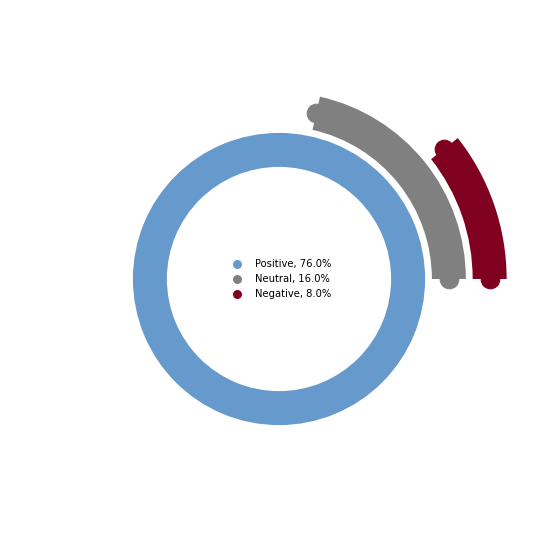

In [139]:
from math import pi
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(projection='polar')
data = [433, 93, 46]

startangle = 0
# colors = ['#4393E5', '#43BAE5', '#7AE6EA']
colors = ['#6699CC', '#808080', '#800020']

xs = [(i * pi * 2)/ 433 for i in data]

ys = [-0.2, 1, 2.2]
left = (startangle * pi * 2)/ 360 

for i, x in enumerate(xs):
    ax.barh(ys[i], x, left=left, height=1, color=colors[i])
    ax.scatter(x+left, ys[i], s=350, color=colors[i], zorder=2)
    ax.scatter(left, ys[i], s=350, color=colors[i], zorder=2)
    
plt.ylim(-4, 4)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Positive, 76.0%', markerfacecolor='#6699CC', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Neutral, 16.0%', markerfacecolor='#808080', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Negative, 8.0%', markerfacecolor='#800020', markersize=10)
]
ax.legend(handles=legend_elements, loc='center', frameon=False)

plt.xticks([])
plt.yticks([])
ax.spines.clear()

plt.show()

In [137]:
from typing import Union

def _percentage(value: Union[int, float], total: Union[int, float]) -> float:
    return round(value / total, 2) * 100

def to_percentage(data: list[Union[int, float]]) -> list[float]:
    total = sum(data)
    total_list = [total] * len(data)
    return list(
        map(lambda value, total: _percentage(value, total), data, total_list)
    )